In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plot_helpers import *
import seaborn as sns
import pandas as pd
from plot_helpers import *
from operator import itemgetter
from scipy.stats import invwishart
import time
import random
import pymc3 as pm




C:\Users\sbezo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dtypes = {"hamiltonian": str, "hamiltonian_brief": str, "n0": np.float64, "En0": np.float64, "method": str, \
          "mbpt_order": np.float64,"set_id": str, "reference": str}
mytypes = {"n0": np.float64, "En0": np.float64}
dt = pd.read_csv("data/saturation_points.csv", comment = "#", usecols=[2,3])

x = dt["n0"]
y = dt["En0"]
                 

reg = np.polyfit(x, y, 1)  #TODO: not sure if 1/y is correct weights value
print(reg)



[-98.17086885   1.44984922]


C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


C:\Users\sbezo\AppData\Local\Temp\ipykernel_15656\2211619761.py:10: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1000, step, start=start, progressbar=False)
C:\Users\sbezo\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$P(\sigma)$, $P(\beta_1)$, $P(\beta_0)$]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to

{'$P(\\beta_0)$': 1.7787778240035652, '$P(\\beta_1)$': -100.89479592445232, '$P(\\sigma)$_log__': -0.4960281297671101, '$P(\\sigma)$': 0.608944511364683}


C:\Users\sbezo\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:214: UserWarning: A valid var_name should be provided, found {'b', 's'} expected from {'$P(\\sigma)$', '$P(\\beta_0)$', '$P(\\beta_1)$'}
  warnings.warn(


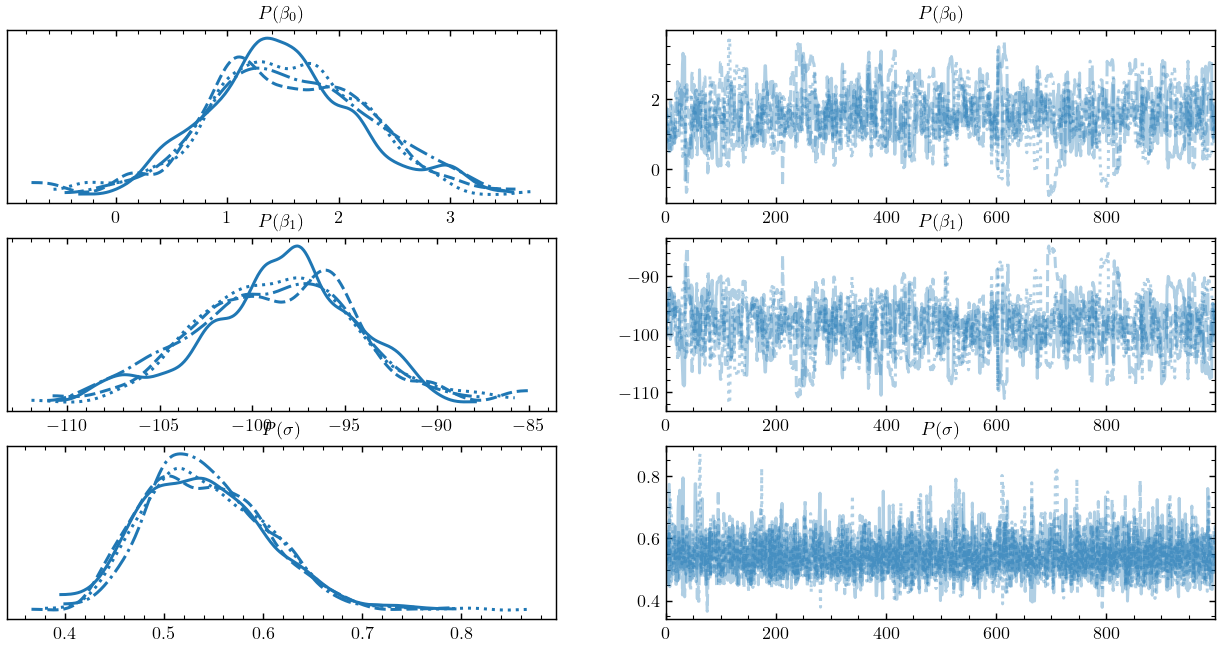

<Figure size 1040x1300 with 0 Axes>

In [3]:
 with pm.Model() as model:
        
    beta_0 = pm.Normal('$P(\\beta_0)$', mu=1.5, sd=1)
    beta_1 = pm.Normal('$P(\\beta_1)$', mu=-100, sd=50)
    sigma = pm.InverseGamma('$P(\sigma)$', alpha=6, beta=5) #mean = 1 varience = .5^2
    y_est =  beta_0 + beta_1 * x
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(1000, step, start=start, progressbar=False)
    print(trace[0])
    fig = pm.traceplot(trace, lines={'beta_0': 4, 'beta_1': 2, 'sigma': 2})
    plt.figure(figsize=(8, 10))
    plt.show()

In [4]:
density = np.linspace(.1,.2,100)
sumArray = [0] * 100
for i in range(100):
    for line in range(len(trace)):
        sumArray[i] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i]) + sumArray[i]
    sumArray[i] = sumArray[i] / len(trace)

y_average = sumArray
y_max = [0] * 100
y_min = [0] * 100
temp_array = [0] * len(trace)

for i in range(100):
    for line in range(len(trace)):
          temp_array[line] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i])
    temp_array = np.sort(temp_array)
    y_max[i] = temp_array[974] 
    y_min[i] = temp_array[25]
    




In [5]:
#Data
prior_mean_0 = np.array([0.16, -15.9])
prior_psi_0 = np.array([[.0001,0],[0,.1]])
prior_mean_x = 0.16
prior_mean_y = -15.9

df = pd.read_csv("data/satpoints_rmf.csv", comment="#", usecols = ['rho0','E/A'])
df1 = pd.read_csv("data/satpoints_skyrme.csv", comment="#", usecols = ['rho0','E/A'])
data1 = np.loadtxt("data/forChristan_samples1.csv", delimiter=',')

def hartree_code(filepath):
    data = pd.read_fwf(filepath, comment='#', header=None)
    data_str = (data.loc[2,0])
    data_val = data_str.strip('][').split(', ')
    A_mean = float(data_val[0])
    B_mean = float(data_val[1])
    Cov = float(data_val[2])*float(data_val[3])*float(data_val[4])
    A_std = float(data_val[2])
    B_std = float(data_val[3])
    return (A_mean, B_mean, Cov, A_std, B_std)

A_12, B_12, Cov_12, A_std_12, B_std_12 = hartree_code("saturation/RMF012/CovEllipse.com")
A_16, B_16, Cov_16, A_std_16, B_std_16 = hartree_code("saturation/RMF016/CovEllipse.com")
A_22, B_22, Cov_22, A_std_22, B_std_22 = hartree_code("saturation/RMF022/CovEllipse.com")
A_28, B_28, Cov_28, A_std_28, B_std_28 = hartree_code("saturation/RMF028/CovEllipse.com") 
A_32, B_32, Cov_32, A_std_32, B_std_32 = hartree_code("saturation/RMF032/CovEllipse.com") 


#Data Jorge
jorge_cov_1 = np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]])
jorge_mean_1 = np.array([A_12, B_12])
jorge_cov_2 = np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]])
jorge_mean_2 = np.array([A_16, B_16])
jorge_cov_3 = np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]])
                       
jorge_mean_3 =  np.array([A_22, B_22])
                       
jorge_cov_4 = np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]])
                       
jorge_mean_4 = np.array([A_28, B_28])
                       
jorge_cov_5 = np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]])
                       
jorge_mean_5 = np.array([A_32, B_32])
                       
data_Jorge1 = pd.DataFrame(np.random.multivariate_normal([A_12,B_12],jorge_cov_1,1000))
data_Jorge2 = pd.DataFrame(np.random.multivariate_normal([A_16,B_16],jorge_cov_2,1000)) 
data_Jorge3 = pd.DataFrame(np.random.multivariate_normal([A_22,B_22],jorge_cov_3,1000))  
data_Jorge4 = pd.DataFrame(np.random.multivariate_normal([A_28,B_28],jorge_cov_4,1000))
data_Jorge5 = pd.DataFrame(np.random.multivariate_normal([A_32,B_32],jorge_cov_5,1000))


#Schunck 
data_Schunck1 = pd.DataFrame(np.loadtxt("data/forChristan_samples1.csv", delimiter=','))
data_Schunck2 = pd.DataFrame(np.loadtxt("data/forChristan_samples2.csv", delimiter=','))
data_Schunck3 = pd.DataFrame(np.loadtxt("data/forChristan_samples3.csv", delimiter=','))


#RMF
data_RMF =pd.DataFrame(df)

#Skyrme
data_Skyrme =pd.DataFrame(df1)

#McDonnell
McDonnell_mean = np.array([np.mean([0.155,0.165]),np.mean([-16, -15.5])])
McDonnell_cov = np.diag([0.005,0.25])**2
data_McDonnell = pd.DataFrame(np.random.multivariate_normal(McDonnell_mean,McDonnell_cov,1000))



dtypes={"Label":str, "rho0":np.float64, "E/aA": np.float64}
data_skyrme=pd.read_csv("data/satpoints_skyrme.csv", comment="#", dtype=dtypes)
data_rmf=pd.read_csv("data/satpoints_rmf.csv", comment="#", dtype=dtypes)
data_FC1=pd.read_csv("data/forChristan_samples1.csv",comment="#", names=["rho0","E/A"])
data_FC2=pd.read_csv("data/forChristan_samples2.csv",comment="#", names=["rho0","E/A"])
data_FC3=pd.read_csv("data/forChristan_samples3.csv",comment="#", names=["rho0","E/A"])

def import_fwf_data(filepath, column_name):
    data = pd.read_fwf(filepath, skiprows=7, comment='#', usecols=column_name)
    return data.rename(columns={column_name[0]:"rho0", column_name[1]:"E/A"})
                       
data_RMF012_1 = import_fwf_data("saturation/RMF012/CovEllipse.out", ["A39","B39"])
data_RMF012_2 = import_fwf_data("saturation/RMF012/CovEllipse.out", ["A95","B95"])
data_RMF016_1 = import_fwf_data("saturation/RMF016/CovEllipse.out", ["A39","B39"])
data_RMF016_2 = import_fwf_data("saturation/RMF016/CovEllipse.out", ["A95","B95"])
data_RMF022_1 = import_fwf_data("saturation/RMF022/CovEllipse.out", ["A39","B39"])
data_RMF022_2 = import_fwf_data("saturation/RMF022/CovEllipse.out", ["A95","B95"])
data_RMF028_1 = import_fwf_data("saturation/RMF028/CovEllipse.out", ["A39","B39"])
data_RMF028_2 = import_fwf_data("saturation/RMF028/CovEllipse.out", ["A95","B95"])
data_RMF032_1 = import_fwf_data("saturation/RMF032/CovEllipse.out", ["A39","B39"])
data_RMF032_2 = import_fwf_data("saturation/RMF032/CovEllipse.out", ["A95","B95"])

def insert_type(typename, data):
    data["type"]=typename
    return data


insert_type("Skyrme", data_skyrme)
insert_type("RMF", data_rmf)


def insert_type_and_label(typename, labelname, data):
    data["type"]=typename
    data["Label"]=labelname
    return data

insert_type_and_label("Schunck", "UNDEF", data_FC1)
insert_type_and_label("Schunck", "UNDEF", data_FC2)
insert_type_and_label("Schunck", "UNDEF", data_FC3)
insert_type_and_label("RMF012", "temp", data_RMF012_1)
insert_type_and_label("RMF012", "temp", data_RMF012_2)
insert_type_and_label("RMF016", "temp", data_RMF016_1)
insert_type_and_label("RMF016", "temp", data_RMF016_2)
insert_type_and_label("RMF022", "temp", data_RMF022_1)
insert_type_and_label("RMF022", "temp", data_RMF022_2)
insert_type_and_label("RMF028", "temp", data_RMF028_1)
insert_type_and_label("RMF028", "temp", data_RMF028_2)
insert_type_and_label("RMF032", "temp", data_RMF032_1)
insert_type_and_label("RMF032", "temp", data_RMF032_2)



data=pd.concat([data_skyrme, data_rmf, data_FC1, data_FC2, data_FC3, data_RMF012_1, data_RMF012_2, data_RMF016_1, data_RMF016_2, data_RMF022_1, data_RMF022_2, data_RMF028_1, data_RMF028_2, data_RMF032_1, data_RMF032_2])

data.head(n=10000)


,Label,rho0,E/A,type
0,SLy4,0.160000,-15.972000,Skyrme
1,UNEDF0,0.160530,-16.056000,Skyrme
2,UNEDF1,0.158710,-15.800000,Skyrme
3,UNEDF2,0.156310,-15.800000,Skyrme
4,KDE0v1,0.165000,-16.230000,Skyrme
...,...,...,...,...
3976,UNDEF,0.155594,-15.714904,Schunck
3977,UNDEF,0.155445,-15.731806,Schunck
3978,UNDEF,0.155052,-15.755521,Schunck
3979,UNDEF,0.155543,-15.802464,Schunck


In [129]:
## posterior function:

def params_init(data, mu_0, kappa_0, psi_0):
    mu_0 = np.array(mu_0) ## random initialization of mu_s for two distribution
    mean_data = (np.mean(data, axis = 0))
    inv_psi_0 = np.linalg.inv(psi_0)
    dim = mu_0.shape[0]
    nu_0 = dim + 1
    n = data.shape[0]
    
    sum_square_0 = np.sum(np.square(data['X_0']-mean_data[0]))
    sum_square_1 = np.sum(np.square(data['X_1']-mean_data[1]))
    
    sum_squares = np.array([sum_square_0,sum_square_1])
    mu_n = np.array(((kappa_0 * mu_0) + (n * mean_data)) / (kappa_0 + n))
    kappa_n = kappa_0 + n
    nu_n = nu_0 + n
    psi_n = psi_0 + sum_squares + kappa_0 * n / float(kappa_0 + n) * np.array(np.matrix(mean_data - mu_0).T * np.matrix(mean_data - mu_0))
    
    params_dict = {"sum_squares":sum_squares, "mu_n":mu_n, "kappa_n": kappa_n, "nu_n": nu_n, "psi_n": psi_n}
    return(params_dict)
    
    
    
def model(data,mu_n,kappa_n,nu_n,psi_n):
    sigma =  invwishart.rvs(nu_n, psi_n, size=1, random_state=None)
    mu = np.random.multivariate_normal(np.array(mu_n),np.matrix(sigma/kappa_n))
    X_p = np.random.multivariate_normal(mu,sigma)
    return({'sigma':sigma, 'mu':mu, 'X_p':X_p})

def model_iter(data, mu_0, kappa_0, psi_0, iter):
    
    params_dict = params_init(data, mu_0, kappa_0, psi_0)
    sum_squares, mu_n, kappa_n, nu_n, psi_n = itemgetter('sum_squares','mu_n','kappa_n','nu_n','psi_n' )(params_dict)
    
    mu_list = []
    X_list = []
    sigma_list = []

    for i in range(iter):
        model_i = model(data,mu_n,kappa_n,nu_n,psi_n)
        sigma_i, mu_i, X_pi = itemgetter('sigma','mu','X_p')(model_i)
        
        mu_list.append(mu_i)
        X_list.append(X_pi)
        sigma_list.append(sigma_i)
        
    return({'mu_list':mu_list, 'X_list':X_list, 'sigma_list':sigma_list})
    

def Jorge():
    frame_list_5 = [data_Jorge1, data_Jorge2, data_Jorge3, data_Jorge4, data_Jorge5]
    chosen_Jorge = random.choice(frame_list_5)
    data = chosen_Jorge.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)
    
def Schunck():     #Choose Orange remove actual data, grey box saturation plot legend, make prior posterior dashed, fix legend,
    data = data_Schunck1.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)
    data = data_Schunck1.sample(1, replace=True)
def RMF():
    data = data_RMF.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)

def Skyrme():
    data = data_Skyrme.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)
    
def McDonnell():
    data = data_McDonnell.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)


samples = pd.concat([Jorge(), Schunck(), RMF(), Skyrme(), McDonnell()], ignore_index = True)


def Universe_iter(iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []
    
    for i in range(iterations):
        samples = pd.concat([Jorge(), Schunck(), RMF(), Skyrme(), McDonnell()], ignore_index = True)
        mod = model_iter(samples, prior_mean_0, 0, prior_psi_0, 10)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(mod) 
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)
        
    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})


#Model Results
Results = Universe_iter(100)

#Model Results Summary
mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(Results)



mu_s_results = pd.DataFrame(np.array(mu_list).reshape(1000,2))
mu_s_results.columns = ['mu_0','mu_1']
posterior_mean = np.mean(mu_s_results, axis = 0)

X_pred_results = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_results.columns = ['X_0','X_1']
X_pred_mean = np.mean(X_pred_results, axis = 0)

sigma_array_results = np.array(sigma_list)
sigma_array_reshape_results = sigma_array_results.reshape(1000,2*2)
posterior_sigma_mean = np.reshape(np.mean(sigma_array_reshape_results,axis = 0), (2,2))


Text(0, 0.5, 'Saturation Energy $E_0/A$ [MeV]')

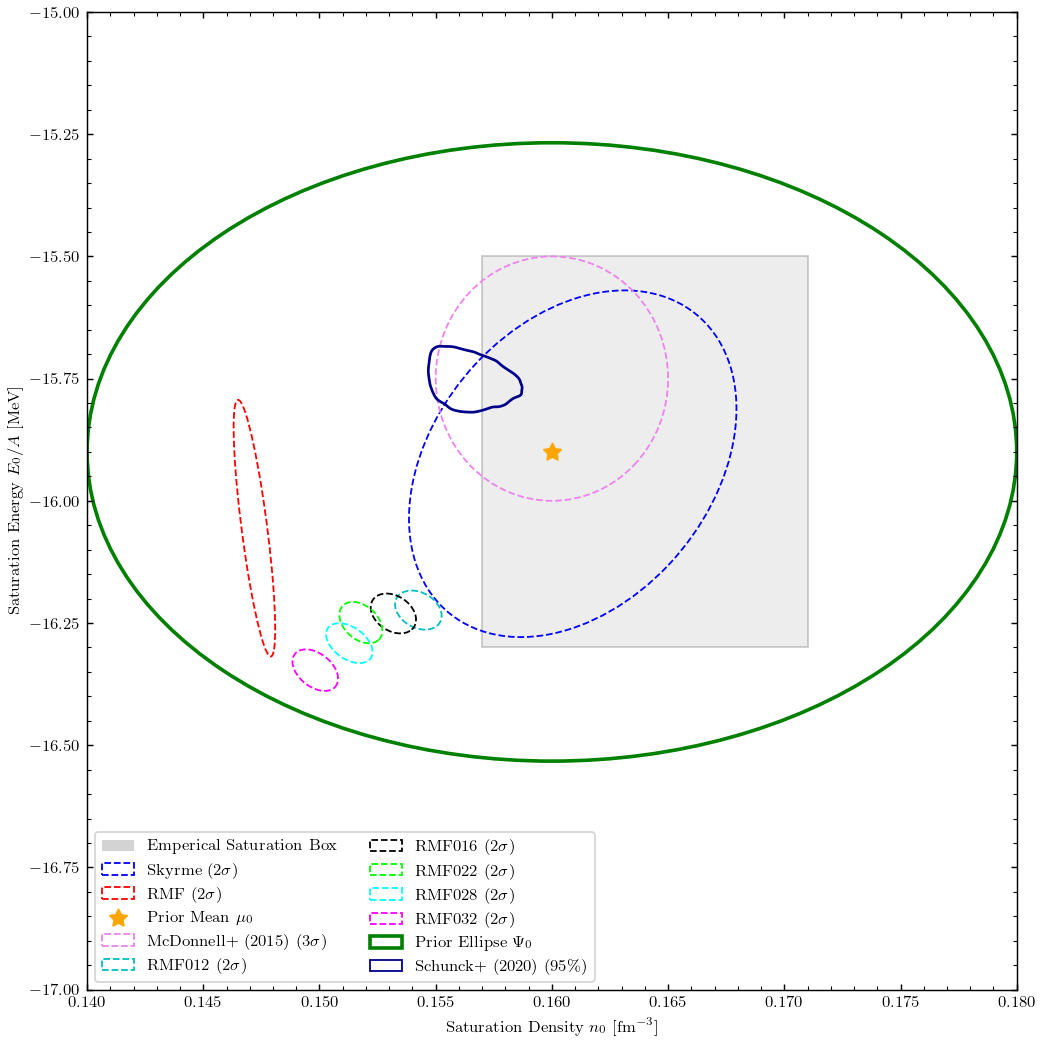

In [101]:
#Plotting

fig, ax = plt.subplots(1, 1, figsize=(304.80*cm, 8), constrained_layout=True)

label=[]


plot_empirical_saturation(ax=ax, zorder=-3, label=f"Emperical Saturation Box")
label.append(Ellipse((0, 0), width=1, height=1, facecolor='lightgrey',  label=f"Emperical Saturation Box"))

for imodel,model in enumerate(("Skyrme", "RMF")):
    masked_data=data[data["type"]==model]
    color=colorset[imodel]
    label.append(confidence_ellipse(masked_data["rho0"], masked_data["E/A"], 
                       ax, n_std=2.0, facecolor='none',edgecolor=color, show_scatter=False, linestyle='--', 
                       label=f"{model} (2$\\sigma$)"))
    

label.append(ax.scatter(prior_mean_x,prior_mean_y, alpha = 1, s=100, marker=(5,1), label=f"Prior Mean $\\mu_0$", c='orange'))   

label.append(confidence_ellipse_mean_cov(np.array([np.mean([0.155,0.165]),np.mean([-16, -15.5])]), np.diag([0.005,0.25])**2, 
                            ax=ax, n_std=1, facecolor='none', edgecolor='violet', linestyle='--', 
                            label=f"McDonnell+ (2015) (3$\\sigma$)"))


label.append(confidence_ellipse_mean_cov(np.array([A_12, B_12]), np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="c", linestyle='--', 
                            label=f"RMF012 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_16, B_16]), np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="k", linestyle='--', 
                            label=f"RMF016 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_22, B_22]), np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]]),
                           ax=ax, n_std=2,facecolor='none', edgecolor="lime", linestyle='--', 
                            label=f"RMF022 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_28, B_28]), np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="aqua", linestyle='--', 
                            label=f"RMF028 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_32, B_32]), np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]]),
                           ax=ax, n_std=2, facecolor="none", edgecolor="magenta", linestyle='--', 
                            label=f"RMF032 (2$\\sigma$)"))


label.append(confidence_ellipse_mean_cov(prior_mean_0,prior_psi_0, ax=ax, n_std=2, facecolor='none', edgecolor ='green', 
                            label=f"Prior Ellipse $\\Psi_0$", linewidth=2))


sns.kdeplot(x=data1[:,0], y=data1[:,1], fill=False, levels=[.05,1], color='darkblue')
label.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="darkblue", label=f"Schunck+ (2020) (95\%)"))


ax.set_xlim(0.14, 0.18)
ax.set_ylim(-17, -15.)
ax.legend(loc='best', fontsize='medium', ncol=2, handles=label)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')

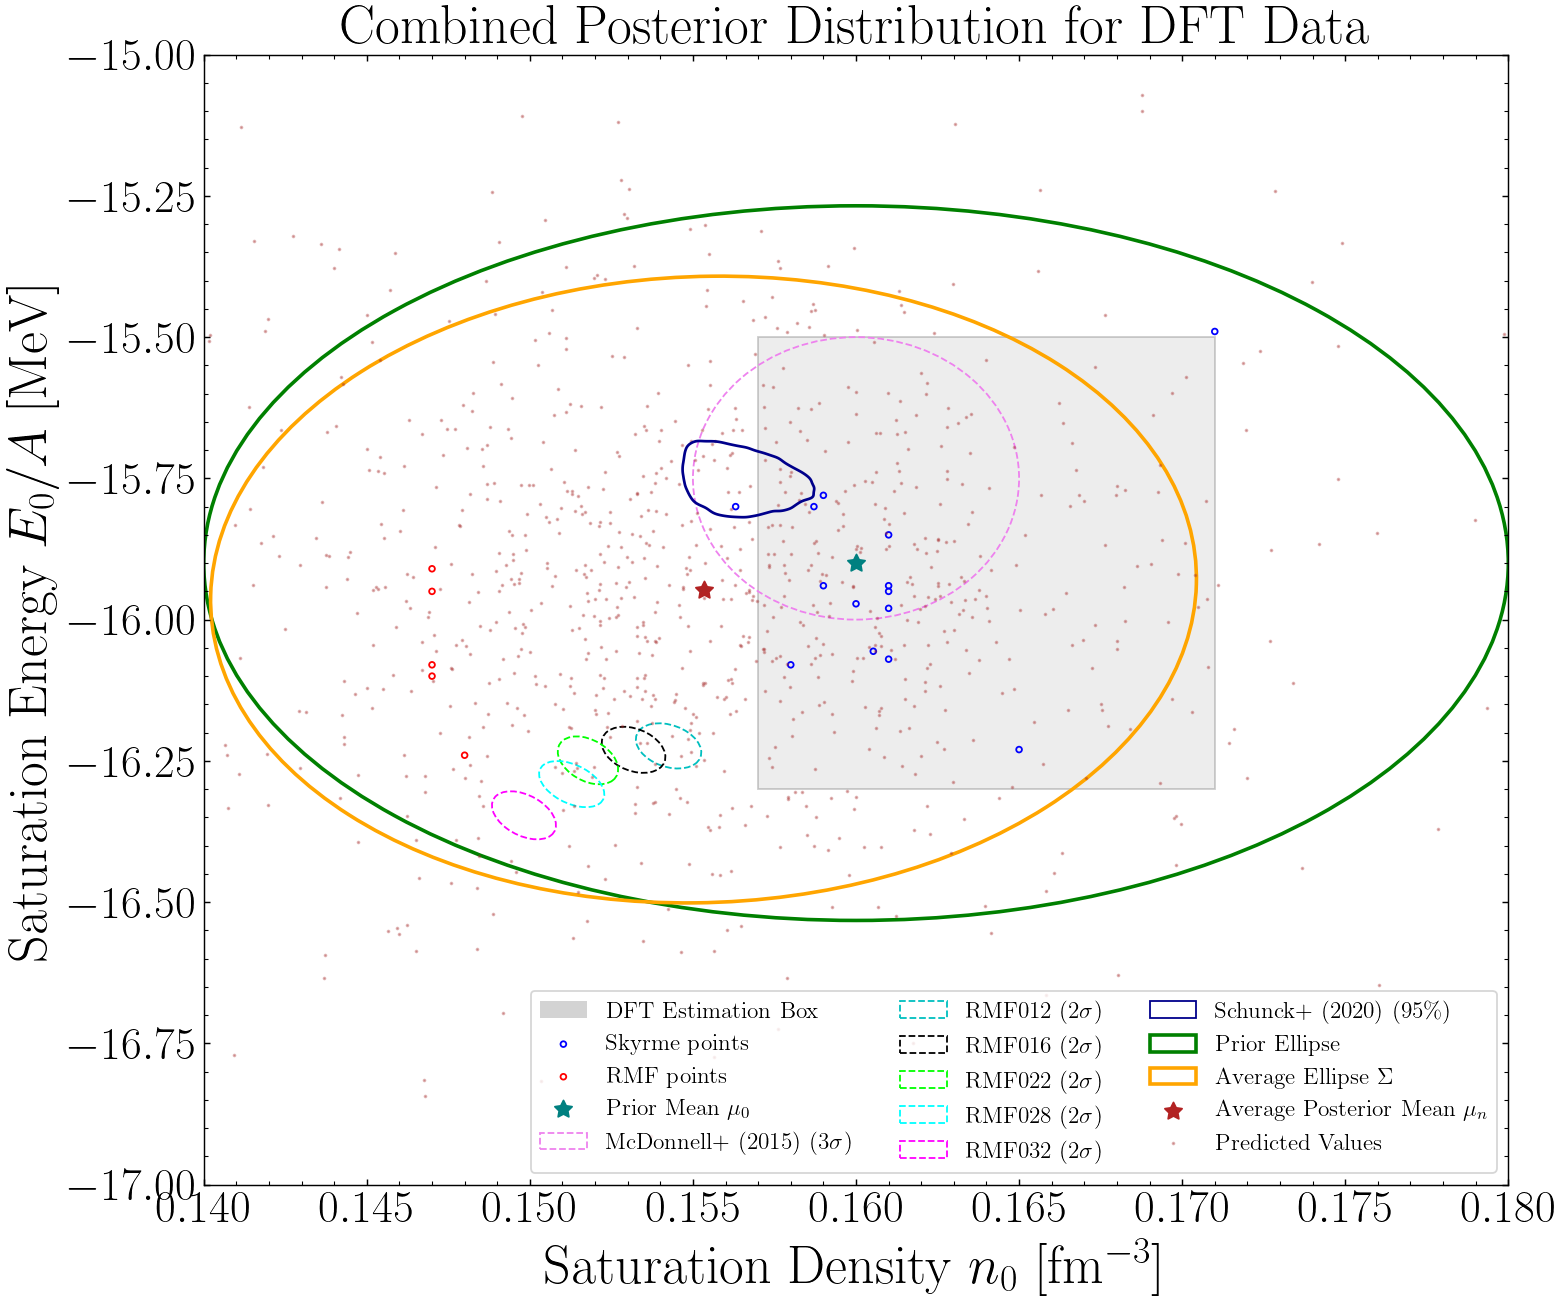

In [131]:
#Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)
label=[]

plot_empirical_saturation(ax=ax, zorder=-3, label=f"DFT estimation box")
label.append(Ellipse((0, 0), width=1, height=1, facecolor='lightgrey',  label=f"DFT Estimation Box"))


#for imodel,model in enumerate(("Skyrme", "RMF")):
    #masked_data=data[data["type"]==model]
   # color=colorset[imodel]
    #label.append(confidence_ellipse(masked_data["rho0"], masked_data["E/A"], 
                       #ax, n_std=2.0, facecolor='none',edgecolor=color, show_scatter=False, linestyle='--', 
                       #label=f"{model} (2$\\sigma$)"))

for imodel,model in enumerate(("Skyrme", "RMF")):
    masked_data=data[data["type"]==model]
    color=colorset[imodel]
    label.append(ax.scatter(masked_data["rho0"], masked_data["E/A"], 
                        alpha=1, s=10,  marker='o', facecolor='none',edgecolor=color, 
                       label=f"{model} points"))
    
label.append(ax.scatter(prior_mean_x,prior_mean_y, alpha = 1, s=100, marker=(5,1), label=f"Prior Mean $\\mu_0$", c='teal'))   

label.append(confidence_ellipse_mean_cov(np.array([np.mean([0.155,0.165]),np.mean([-16, -15.5])]), np.diag([0.005,0.25])**2, 
                            ax=ax, n_std=1, facecolor='none', edgecolor='violet', linestyle='--', 
                            label=f"McDonnell+ (2015) (3$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_12, B_12]), np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="c", linestyle='--', 
                            label=f"RMF012 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_16, B_16]), np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="k", linestyle='--', 
                            label=f"RMF016 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_22, B_22]), np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]]),
                           ax=ax, n_std=2,facecolor='none', edgecolor="lime", linestyle='--', 
                            label=f"RMF022 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_28, B_28]), np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="aqua", linestyle='--', 
                            label=f"RMF028 (2$\\sigma$)"))

label.append(confidence_ellipse_mean_cov(np.array([A_32, B_32]), np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]]),
                           ax=ax, n_std=2, facecolor="none", edgecolor="magenta", linestyle='--', 
                            label=f"RMF032 (2$\\sigma$)"))

sns.kdeplot(x=data1[:,0], y=data1[:,1], fill=False, levels=[.05,1], color='darkblue')
label.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="darkblue", label=f"Schunck+ (2020) (95\%)"))

label.append(confidence_ellipse_mean_cov(prior_mean_0,prior_psi_0, ax=ax, n_std=2, facecolor='none', edgecolor ='green', 
                            label=f"Prior Ellipse", linewidth=2))

label.append(confidence_ellipse_mean_cov(posterior_mean, posterior_sigma_mean, ax, n_std= 2, facecolor='none', edgecolor = 'orange'
                            ,  label=f"Average Ellipse $\\Sigma$", linewidth=2 ))

#label.append(ax.scatter(samples['X_0'],samples['X_1'], alpha = 1, s=50, marker=(5,1), label=f"Samples", c='blue'))  


label.append(ax.scatter(posterior_mean[0], posterior_mean[1], alpha = 1, c = 'firebrick', s=100, marker=(5,1), 
           label=f"Average Posterior Mean $\\mu_n$ "))

label.append(ax.scatter(X_pred_results['X_0'],X_pred_results['X_1'],alpha = .33, c = 'brown', s = 1, label = 'Predicted Values'))



ax.set_xlim(0.14, 0.18)
ax.set_ylim(-17, -15.)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.title('Combined Posterior Distribution for DFT Data', fontdict = {'fontsize' : 30})
ax.legend(loc='best', fontsize='x-large', ncol=3, handles=label)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]',fontdict = {'fontsize' : 30})
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]',fontdict = {'fontsize' : 30})
plt.savefig("BayesianMultivariate.pdf")

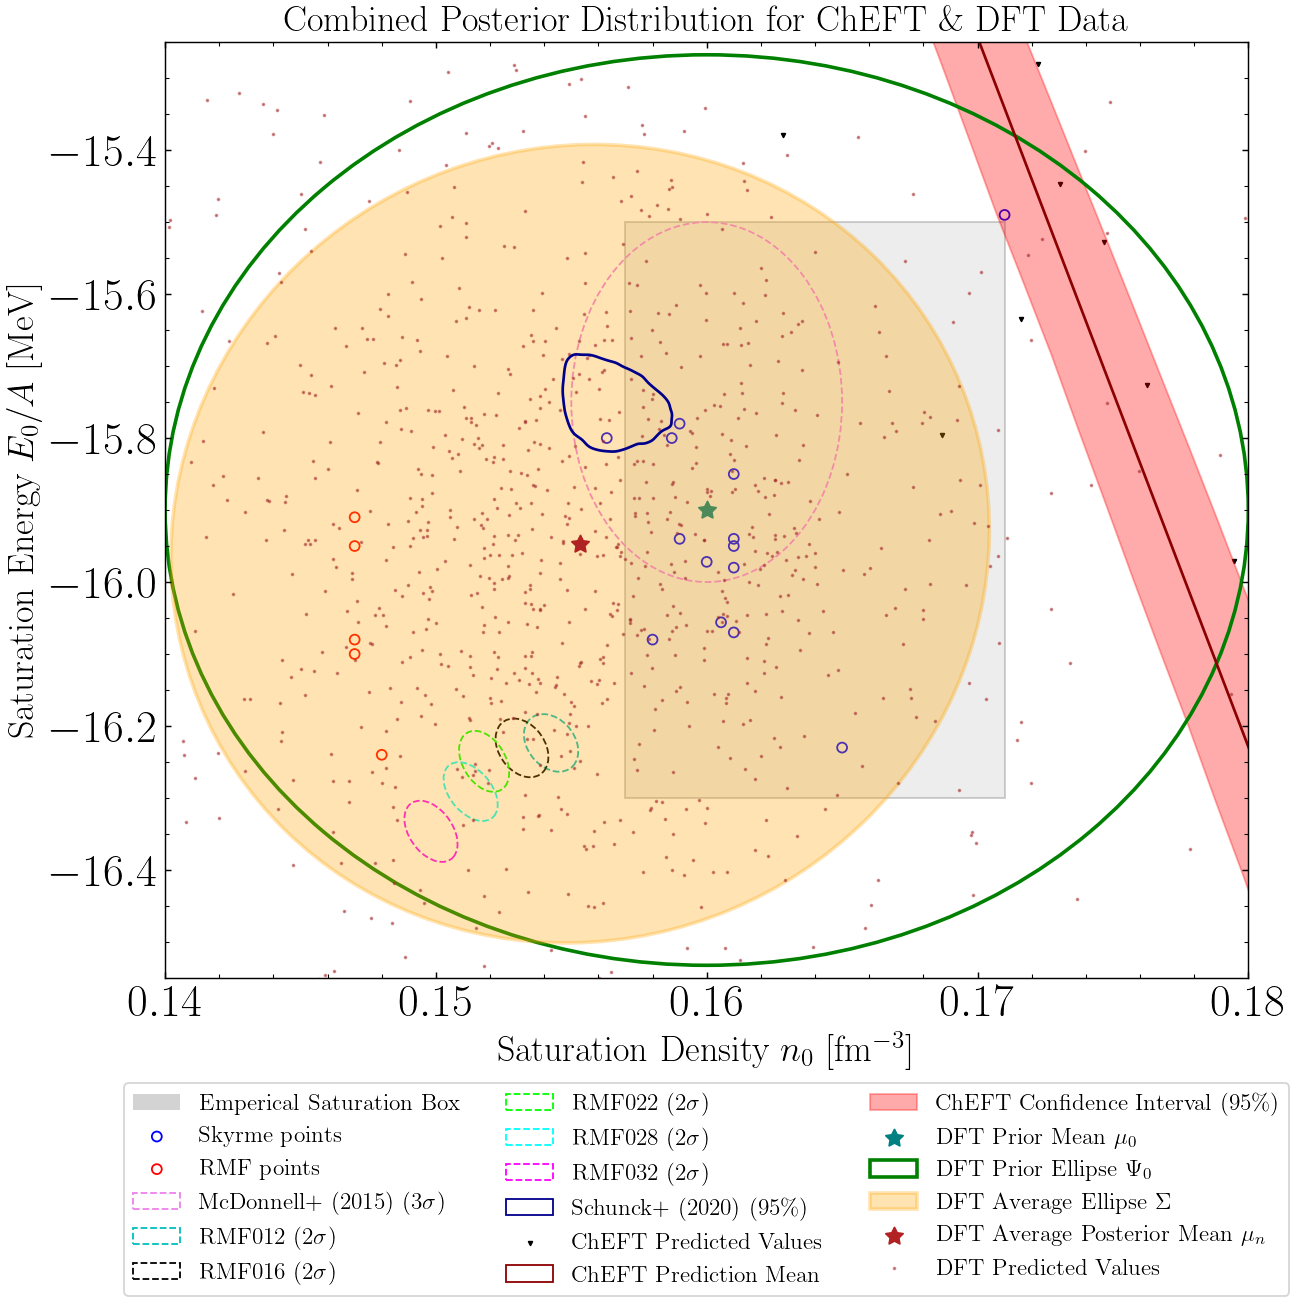

In [132]:
###################

#Money Plot

density = np.linspace(.1,.2,100)
sumArray = [0] * 100
for i in range(100):
    for line in range(len(trace)):
        sumArray[i] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i]) + sumArray[i]
    sumArray[i] = sumArray[i] / len(trace)

y_average = sumArray
y_max = [0] * 100
y_min = [0] * 100
temp_array = [0] * len(trace)

for i in range(100):
    for line in range(len(trace)):
          temp_array[line] = (trace['$P(\\beta_0)$'][line] + trace['$P(\\beta_1)$'][line] * density[i])
    temp_array = np.sort(temp_array)
    y_max[i] = temp_array[974] 
    y_min[i] = temp_array[25]
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)

label_s=[]

plot_empirical_saturation(ax=ax, zorder=-3, label=f"DFT Box")
label_s.append(Ellipse((0, 0), width=1, height=1, facecolor='lightgrey',  label=f"Emperical Saturation Box"))


for imodel,model in enumerate(("Skyrme", "RMF")):
    masked_data=data[data["type"]==model]
    color=colorset[imodel]
    label_s.append(ax.scatter(masked_data["rho0"], masked_data["E/A"], 
                        alpha=1, s=30,  marker='o', facecolor='none',edgecolor=color, 
                       label=f"{model} points"))
    
label_s.append(confidence_ellipse_mean_cov(np.array([np.mean([0.155,0.165]),np.mean([-16, -15.5])]), np.diag([0.005,0.25])**2, 
                            ax=ax, n_std=1, facecolor='none', edgecolor='violet', linestyle='--', 
                            label=f"McDonnell+ (2015) (3$\\sigma$)"))

label_s.append(confidence_ellipse_mean_cov(np.array([A_12, B_12]), np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="c", linestyle='--', 
                            label=f"RMF012 (2$\\sigma$)"))

label_s.append(confidence_ellipse_mean_cov(np.array([A_16, B_16]), np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="k", linestyle='--', 
                            label=f"RMF016 (2$\\sigma$)"))

label_s.append(confidence_ellipse_mean_cov(np.array([A_22, B_22]), np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]]),
                           ax=ax, n_std=2,facecolor='none', edgecolor="lime", linestyle='--', 
                            label=f"RMF022 (2$\\sigma$)"))

label_s.append(confidence_ellipse_mean_cov(np.array([A_28, B_28]), np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="aqua", linestyle='--', 
                            label=f"RMF028 (2$\\sigma$)"))

label_s.append(confidence_ellipse_mean_cov(np.array([A_32, B_32]), np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]]),
                           ax=ax, n_std=2, facecolor="none", edgecolor="magenta", linestyle='--', 
                            label=f"RMF032 (2$\\sigma$)"))

sns.kdeplot(x=data1[:,0], y=data1[:,1], fill=False, levels=[.05,1], color='darkblue')
label_s.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="darkblue", label=f"Schunck+ (2020) (95\%)"))

label_s.append(ax.scatter(x, y, s=4, c='black', label='ChEFT Predicted Values', marker='v'))    

ax.plot(density, y_average, label='ChEFT Prediction Mean', c='darkred') 
label_s.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="darkred", label='ChEFT Prediction Mean'))

label_s.append(ax.fill_between(density, y_min , y_max , color='r', alpha=.33, label= 'ChEFT Confidence Interval ($95\%$)'))

label_s.append(ax.scatter(prior_mean_x,prior_mean_y, alpha = 1, s=100, marker=(5,1), label=f"DFT Prior Mean $\\mu_0$", c='teal'))

label_s.append(confidence_ellipse_mean_cov(prior_mean_0,prior_psi_0, ax=ax, n_std=2, facecolor='none', edgecolor ='green', 
                            label=f"DFT Prior Ellipse $\\Psi_0$", linewidth=2))


#label_s.append(ax.scatter(samples['X_0'],samples['X_1'], alpha = 1, s=100, marker=(5,1), label=f"Samples", c='blue'))  

label_s.append(confidence_ellipse_mean_cov(posterior_mean, posterior_sigma_mean, ax, n_std= 2, alpha=.3, facecolor='orange',edgecolor ='orange'
                            ,  label=f"DFT Average Ellipse $\\Sigma$", linewidth=2))

label_s.append(ax.scatter(posterior_mean[0], posterior_mean[1], alpha = 1, c = 'firebrick', s=100, marker=(5,1), 
           label=f"DFT Average Posterior Mean $\\mu_n$ "))

label_s.append(ax.scatter(X_pred_results['X_0'],X_pred_results['X_1'],alpha = .5, c = 'brown', s = 1, label = 'DFT Predicted Values'))


ax.set_xlim(0.14, 0.18)
ax.set_ylim(-16.55, -15.25)
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15)
plt.title(label='Combined Posterior Distribution for ChEFT \& DFT Data',fontdict = {'fontsize' : 20})
ax.legend(handles=label_s, ncol=3, loc='upper center', bbox_to_anchor=(.5, -0.1), fontsize='x-large')
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]',fontdict = {'fontsize' : 20})
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]',fontdict = {'fontsize' : 20})
plt.savefig("MoneyPlot.pdf")

In [133]:
posterior_mean


mu_0     0.155325
mu_1   -15.946747
dtype: float64

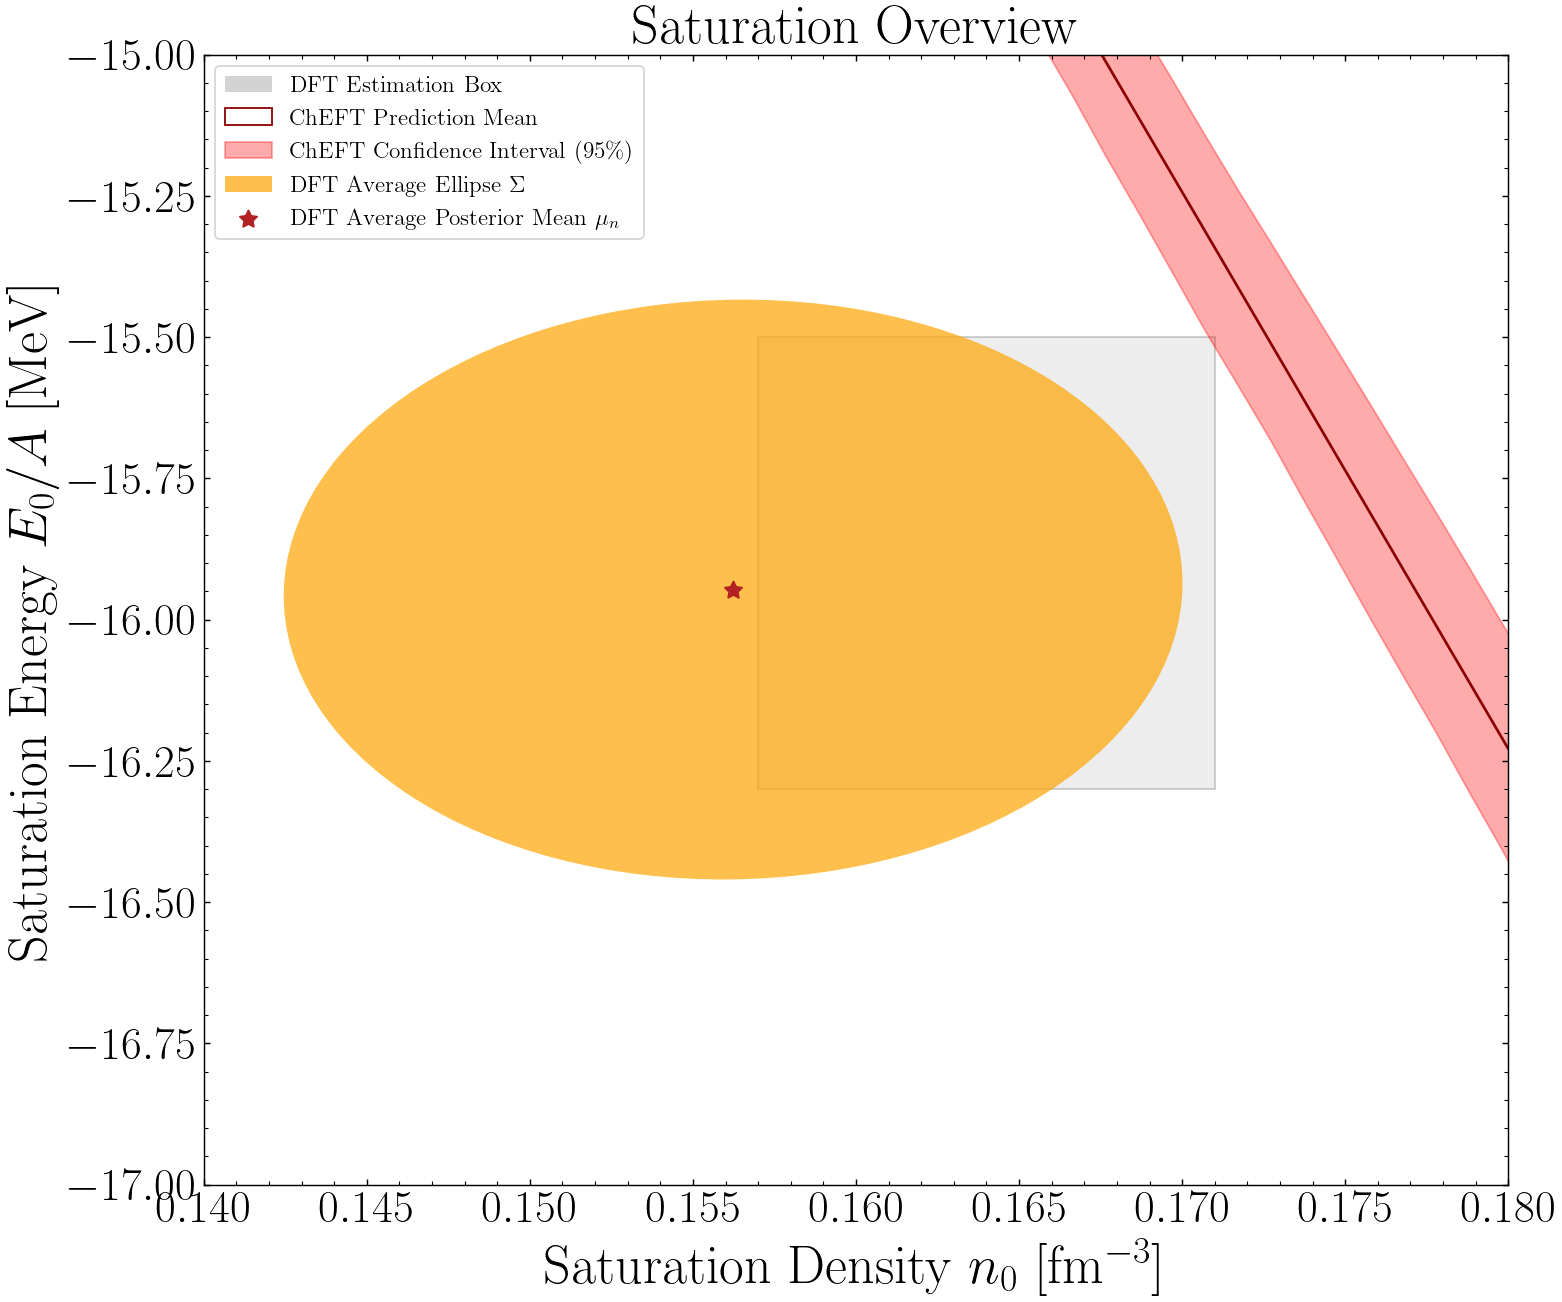

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)

label_s=[]

plot_empirical_saturation(ax=ax, zorder=-3, label=f"DFT estimation Box")
label_s.append(Ellipse((0, 0), width=1, height=1, facecolor='lightgrey',  label=f"DFT Estimation Box"))    

ax.plot(density, y_average, label='ChEFT Prediction Mean', c='darkred') 
label_s.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="darkred", label='ChEFT Prediction Mean'))

label_s.append(ax.fill_between(density, y_min , y_max , color='r', alpha=.33, label= 'ChEFT Confidence Interval ($95\%$)'))

label_s.append(confidence_ellipse_mean_cov(posterior_mean, posterior_sigma_mean, ax, n_std= 2, facecolor='orange'
                            ,  label=f"DFT Average Ellipse $\\Sigma$", linewidth=2, alpha=.7))

label_s.append(ax.scatter(posterior_mean[0], posterior_mean[1], alpha = 1, c = 'firebrick', s=100, marker=(5,1), 
           label=f"DFT Average Posterior Mean $\\mu_n$ "))

ax.set_xlim(0.14, 0.18)
ax.set_ylim(-17, -15.)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.title(label='Saturation Overview',fontdict = {'fontsize' : 30})
ax.legend(handles=label_s, loc='best', fontsize='x-large', ncol=1)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]',fontdict = {'fontsize' : 30})
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]',fontdict = {'fontsize' : 30})
plt.savefig("MoneyPlot2.0.pdf")